In [21]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torchvision import transforms, datasets
import os,PIL,pathlib,warnings

warnings.filterwarnings("ignore")             #忽略警告信息

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
import os,PIL,random,pathlib

data_dir = './weather/'
data_dir = pathlib.Path(data_dir)
data_paths = list(data_dir.glob('*'))
classNames = [data_paths[i].name for i in range(4)]

In [8]:
classNames

['shine', 'rain', 'sunrise', 'cloudy']

In [9]:
train_transforms = transforms.Compose(
[transforms.Resize([224,224]),
transforms.ToTensor(),
transforms.Normalize(
mean = [0.485, 0.456, 0.406],
std = [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
   std=[0.229, 0.224, 0.225])
])

In [10]:
total_data = datasets.ImageFolder(data_dir,transform=train_transforms)

In [11]:
total_data

Dataset ImageFolder
    Number of datapoints: 1125
    Root location: weather
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [12]:
total_data.class_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [13]:
train_size = int(0.8 * len(total_data))
test_size  = len(total_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(total_data, [train_size, test_size])
train_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x7efd61da0f50>,
 <torch.utils.data.dataset.Subset at 0x7efc4814d390>)

In [14]:
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=1)
test_dl = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=1)

In [15]:
for X,y in train_dl:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 3, 224, 224])
Shape of y:  torch.Size([32]) torch.int64


In [16]:
import torch.nn.functional as F

In [17]:
import torch.nn.functional as F

def autopad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

class Conv(nn.Module):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):  # ch_in, ch_out, kernel, stride, padding, groups
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.SiLU() if act is True else (act if isinstance(act, nn.Module) else nn.Identity())

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class Bottleneck(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_, c2, 3, 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))

class C3(nn.Module):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1)  # act=FReLU(c2)
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), dim=1))
    
class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat([x, y1, y2, self.m(y2)], 1))
"""
这个是YOLOv5, 6.0版本的主干网络，这里进行复现
（注：有部分删改，详细讲解将在后续进行展开）
"""
class YOLOv5_backbone(nn.Module):
    def __init__(self):
        super(YOLOv5_backbone, self).__init__()
        
        self.Conv_1 = Conv(3, 64, 3, 2, 2) 
        self.Conv_2 = Conv(64, 128, 3, 2) 
        self.C3_3   = C3(128,128)
        self.Conv_4 = Conv(128, 256, 3, 2) 
        self.C3_5   = C3(256,256)
        self.Conv_6 = Conv(256, 512, 3, 2) 
        self.C3_7   = C3(512,512)
        self.Conv_8 = Conv(512, 1024, 3, 2) 
        self.C3_9   = C3(1024, 1024)
        self.SPPF   = SPPF(1024, 1024, 5)
        
        # 全连接网络层，用于分类
        self.classifier = nn.Sequential(
            nn.Linear(in_features=65536, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=4)
        )
        
    def forward(self, x):
        x = self.Conv_1(x)
        x = self.Conv_2(x)
        x = self.C3_3(x)
        x = self.Conv_4(x)
        x = self.C3_5(x)
        x = self.Conv_6(x)
        x = self.C3_7(x)
        x = self.Conv_8(x)
        x = self.C3_9(x)
        x = self.SPPF(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)

        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
    
model = YOLOv5_backbone().to(device)
model

Using cuda device


YOLOv5_backbone(
  (Conv_1): Conv(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
  )
  (Conv_2): Conv(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
  )
  (C3_3): C3(
    (cv1): Conv(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (cv2): Conv(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (cv3): Conv(
      (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn

In [18]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 训练集的大小
    num_batches = len(dataloader)   # 批次数目, (size/batch_size，向上取整)

    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [19]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小
    num_batches = len(dataloader)          # 批次数目, (size/batch_size，向上取整)
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

In [22]:
import copy

optimizer  = torch.optim.Adam(model.parameters(), lr= 1e-4)
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数

epochs     = 20

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

best_acc = 0    # 设置一个最佳准确率，作为最佳模型的判别指标

for epoch in range(epochs):
    
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, optimizer)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    # 保存最佳模型到 best_model
    if epoch_test_acc > best_acc:
        best_acc   = epoch_test_acc
        best_model = copy.deepcopy(model)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    # 获取当前的学习率
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%, Test_loss:{:.3f}, Lr:{:.2E}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, 
                          epoch_test_acc*100, epoch_test_loss, lr))
    
# 保存最佳模型到文件中
PATH = './best_model.pth'  # 保存的参数文件名
torch.save(model.state_dict(), PATH)

print('Done')

Epoch: 1, Train_acc:57.3%, Train_loss:0.994, Test_acc:25.3%, Test_loss:2.141, Lr:1.00E-04
Epoch: 2, Train_acc:78.2%, Train_loss:0.534, Test_acc:80.9%, Test_loss:0.505, Lr:1.00E-04
Epoch: 3, Train_acc:85.8%, Train_loss:0.400, Test_acc:88.0%, Test_loss:0.290, Lr:1.00E-04
Epoch: 4, Train_acc:90.7%, Train_loss:0.272, Test_acc:90.2%, Test_loss:0.292, Lr:1.00E-04
Epoch: 5, Train_acc:90.2%, Train_loss:0.286, Test_acc:91.6%, Test_loss:0.187, Lr:1.00E-04
Epoch: 6, Train_acc:90.3%, Train_loss:0.266, Test_acc:91.6%, Test_loss:0.215, Lr:1.00E-04
Epoch: 7, Train_acc:91.6%, Train_loss:0.281, Test_acc:89.8%, Test_loss:0.235, Lr:1.00E-04
Epoch: 8, Train_acc:89.8%, Train_loss:0.383, Test_acc:85.8%, Test_loss:0.528, Lr:1.00E-04
Epoch: 9, Train_acc:89.4%, Train_loss:0.324, Test_acc:87.6%, Test_loss:0.273, Lr:1.00E-04
Epoch:10, Train_acc:93.8%, Train_loss:0.178, Test_acc:87.1%, Test_loss:0.378, Lr:1.00E-04
Epoch:11, Train_acc:94.7%, Train_loss:0.207, Test_acc:93.3%, Test_loss:0.181, Lr:1.00E-04
Epoch:12, 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


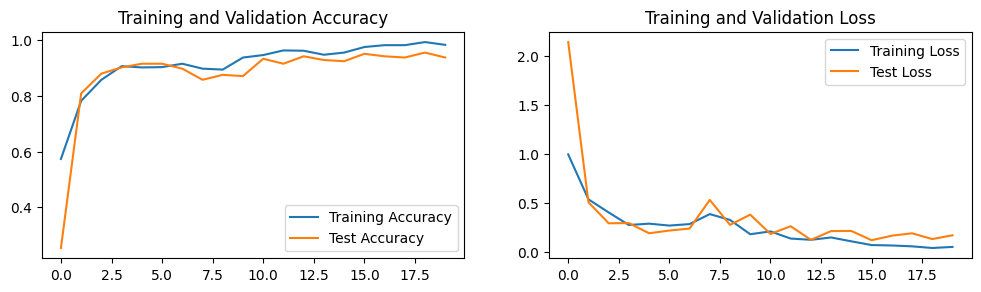

In [23]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()